In [2]:

from pathlib import Path
import pandas as pd, cv2, numpy as np, random, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

PROJ_ROOT = Path.home() / "Computer-Vision-Assignment"
RES_DIR   = PROJ_ROOT / "results"
MET_DIR   = RES_DIR / "metrics"
CROP_DIR  = RES_DIR / "preproc_signs"

df = pd.read_csv(MET_DIR/"preprocessed_signs.csv")
print("Loaded crops:", len(df))


Loaded crops: 810


In [3]:
# Cell 2 — load preprocessed crops and build splits
from pathlib import Path
import pandas as pd
import numpy as np

CROPS_CSV = MET_DIR / "preprocessed_signs.csv"
df = pd.read_csv(CROPS_CSV)

# Keep only files that actually exist (defensive)
df = df[df["crop_path"].apply(lambda p: Path(p).exists())].copy()
print("Loaded crops:", len(df))

# Encode labels → y (consistent ordering)
labels = sorted(df["label"].unique())
label_to_id = {c:i for i,c in enumerate(labels)}
id_to_label = {i:c for c,i in label_to_id.items()}
df["y"] = df["label"].map(label_to_id)

# Split frames
train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

print("Per split counts (crops):",
      {k: v.shape[0] for k,v in dict(train=train_df, val=val_df, test=test_df).items()})
print("Num classes:", len(labels))


Loaded crops: 810
Per split counts (crops): {'train': 557, 'val': 134, 'test': 119}
Num classes: 5


In [4]:
# Cell 3 — OpenCV-only features: HOG (cv2) + HSV histogram
import cv2
import numpy as np
from joblib import dump, load

# HOG for 128x128 windows
hog = cv2.HOGDescriptor(
    _winSize=(128,128),
    _blockSize=(16,16),
    _blockStride=(8,8),
    _cellSize=(8,8),
    _nbins=9
)

def feat_one(path):
    """Return 1D feature vector for a single 128x128 crop."""
    bgr = cv2.imread(path)
    if bgr is None:
        return None
    # Ensure 128x128 (our crops already are, but keep it defensive)
    bgr = cv2.resize(bgr, (128,128), interpolation=cv2.INTER_AREA)

    # HOG
    f_hog = hog.compute(bgr).reshape(-1)

    # HSV histogram (H:12, S:6, V:3 bins)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [12,6,3], [0,180, 0,256, 0,256]).flatten()
    hist = hist / (hist.sum() + 1e-7)

    # concat
    return np.concatenate([f_hog, hist], axis=0).astype(np.float32)

def build_Xy(frame, cache_name):
    """Vectorize crops → X,y with simple disk cache to speed reruns."""
    cache_fp = MET_DIR / cache_name
    if cache_fp.exists():
        data = np.load(cache_fp, allow_pickle=True)
        return data["X"], data["y"]
    feats = []
    for p in frame["crop_path"]:
        f = feat_one(p)
        if f is None:
            # rare read error → skip row
            feats.append(None)
        else:
            feats.append(f)
    # Keep only rows we actually featurized
    ok = [i for i,f in enumerate(feats) if f is not None]
    X = np.vstack([feats[i] for i in ok])
    y = frame.iloc[ok]["y"].to_numpy().astype(np.int32)
    np.savez_compressed(cache_fp, X=X, y=y)
    return X, y

X_train, y_train = build_Xy(train_df, "Xy_train_cv.npz")
X_val,   y_val   = build_Xy(val_df,   "Xy_val_cv.npz")
X_test,  y_test  = build_Xy(test_df,  "Xy_test_cv.npz")

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (557, 8316) (134, 8316) (119, 8316)


In [5]:
# Cell 4 — model training & evaluation (Linear SVM)
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import json
import numpy as np

# Standardize → LinearSVC works better
clf = make_pipeline(
    StandardScaler(with_mean=False),   # sparse-ish, keep with_mean=False
    LinearSVC(C=1.0, class_weight="balanced", max_iter=5000, dual=True, random_state=42)
)
clf.fit(X_train, y_train)

def eval_split(name, X, y):
    yp = clf.predict(X)
    rep = classification_report(y, yp, target_names=labels, output_dict=True, zero_division=0)
    cm  = confusion_matrix(y, yp)
    print(f"\n=== {name} ===")
    print(classification_report(y, yp, target_names=labels, digits=3, zero_division=0))
    return rep, cm

rep_val,  cm_val  = eval_split("VAL",  X_val,  y_val)
rep_test, cm_test = eval_split("TEST", X_test, y_test)

# Save metrics
metrics_path = MET_DIR / "classical_baseline_metrics.json"
with open(metrics_path, "w") as f:
    json.dump({"val":rep_val, "test":rep_test}, f, indent=2)
print("\nSaved metrics →", metrics_path)

# Optional: save confusion matrices as .npy (lightweight)
np.save(MET_DIR / "cm_val.npy",  cm_val)
np.save(MET_DIR / "cm_test.npy", cm_test)
print("Saved confusion matrices.")



=== VAL ===
                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1      0.905     1.000     0.950        19
                           other-sign      0.964     0.883     0.922        60
             regulatory--no-entry--g1      0.900     0.947     0.923        19
                 regulatory--stop--g1      0.842     0.941     0.889        17
                regulatory--yield--g1      1.000     1.000     1.000        19

                             accuracy                          0.933       134
                            macro avg      0.922     0.954     0.937       134
                         weighted avg      0.936     0.933     0.933       134


=== TEST ===
                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1      0.952     0.952     0.952        21
                           other-sign      0.933     0.857     0.894        49
             regulato

In [7]:
## CELL 5: Model 2 - Training Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print("\n--- Training Random Forest Classifier ---")

# We create a new pipeline for the Random Forest
rf_clf = make_pipeline(
    StandardScaler(with_mean=False), # Match your setting from Cell 4
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
)

print("Training RF...")
rf_clf.fit(X_train, y_train) # Uses X_train, y_train from Cell 3

# --- Evaluate RF ---
# We use the 'labels' variable from your Cell 2
print("\n--- RF Validation Results ---")
y_val_pred_rf = rf_clf.predict(X_val)
print(classification_report(y_val, y_val_pred_rf, target_names=labels, digits=3, zero_division=0))

print("\n--- RF Test Results ---")
y_test_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_test_pred_rf, target_names=labels, digits=3, zero_division=0))

# --- Save RF metrics ---
rf_rep_val = classification_report(y_val, y_val_pred_rf, target_names=labels, output_dict=True, zero_division=0)
rf_rep_test = classification_report(y_test, y_test_pred_rf, target_names=labels, output_dict=True, zero_division=0)

rf_metrics_path = MET_DIR / "classical_rf_metrics.json"
with open(rf_metrics_path, "w") as f:
    json.dump({"val": rf_rep_val, "test": rf_rep_test}, f, indent=2)
print(f"\nSaved RF metrics -> {rf_metrics_path}")


--- Training Random Forest Classifier ---
Training RF...

--- RF Validation Results ---
                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1      0.947     0.947     0.947        19
                           other-sign      0.891     0.950     0.919        60
             regulatory--no-entry--g1      0.895     0.895     0.895        19
                 regulatory--stop--g1      1.000     0.824     0.903        17
                regulatory--yield--g1      1.000     0.947     0.973        19

                             accuracy                          0.925       134
                            macro avg      0.947     0.913     0.928       134
                         weighted avg      0.929     0.925     0.925       134


--- RF Test Results ---
                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1      1.000     0.762     0.865        21
             

--- Visualizing Image Gradients (The building block of HOG) ---
NOTE: 'skimage' could not be installed. Visualizing gradients instead.


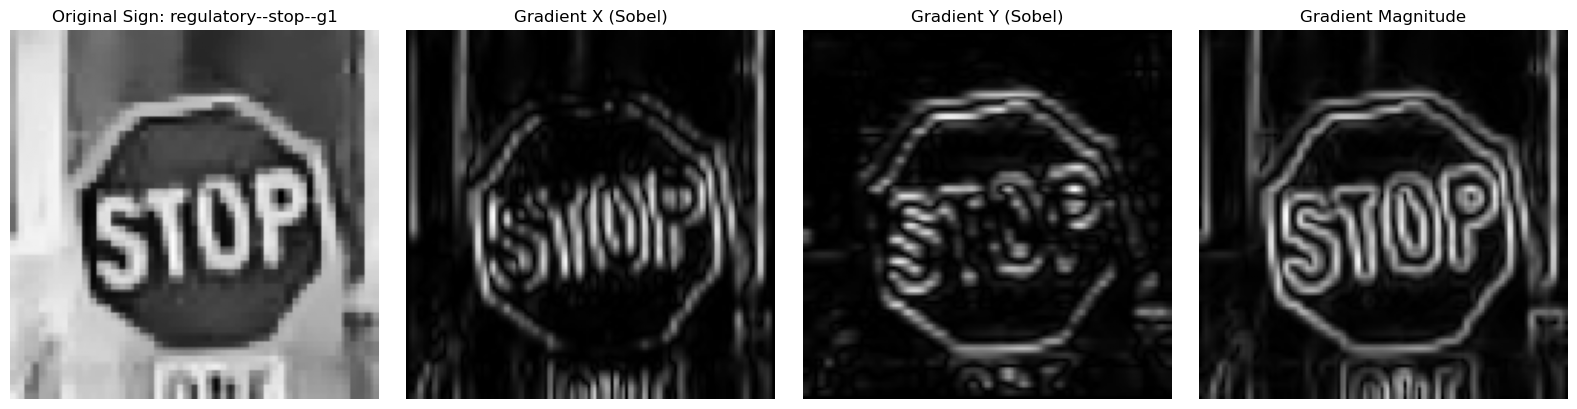

In [14]:
## CELL 6: Gradient Visualization (HOG Input)
import cv2
import numpy as np
from pathlib import Path # <-- FIX IS HERE

# Define the figure directory
FIG_DIR = Path("results/figures") 
FIG_DIR.mkdir(exist_ok=True) # Also added this to be safe

print("--- Visualizing Image Gradients (The building block of HOG) ---")
print("NOTE: 'skimage' could not be installed. Visualizing gradients instead.")

# Get one sample image from your validation set (from Cell 2)
sample_path = val_df['crop_path'].iloc[0] 
sample_label = val_df['label'].iloc[0]

# 1. Load the image
img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128)) # Ensure 128x128

# 2. Calculate Gradients (what HOG is built from)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobelx_abs = np.absolute(sobelx)
sobelx_norm = np.uint8(255 * sobelx_abs / np.max(sobelx_abs))

sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
sobely_abs = np.absolute(sobely)
sobely_norm = np.uint8(255 * sobely_abs / np.max(sobely_abs))

magnitude = np.sqrt(sobelx**2 + sobely**2)
magnitude_norm = np.uint8(255 * magnitude / np.max(magnitude))

# 3. Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title(f'Original Sign: {sample_label}')
axes[0].axis('off')

axes[1].imshow(sobelx_norm, cmap=plt.cm.gray)
axes[1].set_title('Gradient X (Sobel)')
axes[1].axis('off')

axes[2].imshow(sobely_norm, cmap=plt.cm.gray)
axes[2].set_title('Gradient Y (Sobel)')
axes[2].axis('off')

axes[3].imshow(magnitude_norm, cmap=plt.cm.gray)
axes[3].set_title('Gradient Magnitude')
axes[3].axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / "hog_gradient_visualization.png") # <-- This line will now work
plt.show()

--- Analyzing Misclassifications (SVM Test Set) ---
Found 10 misclassifications in the test set.


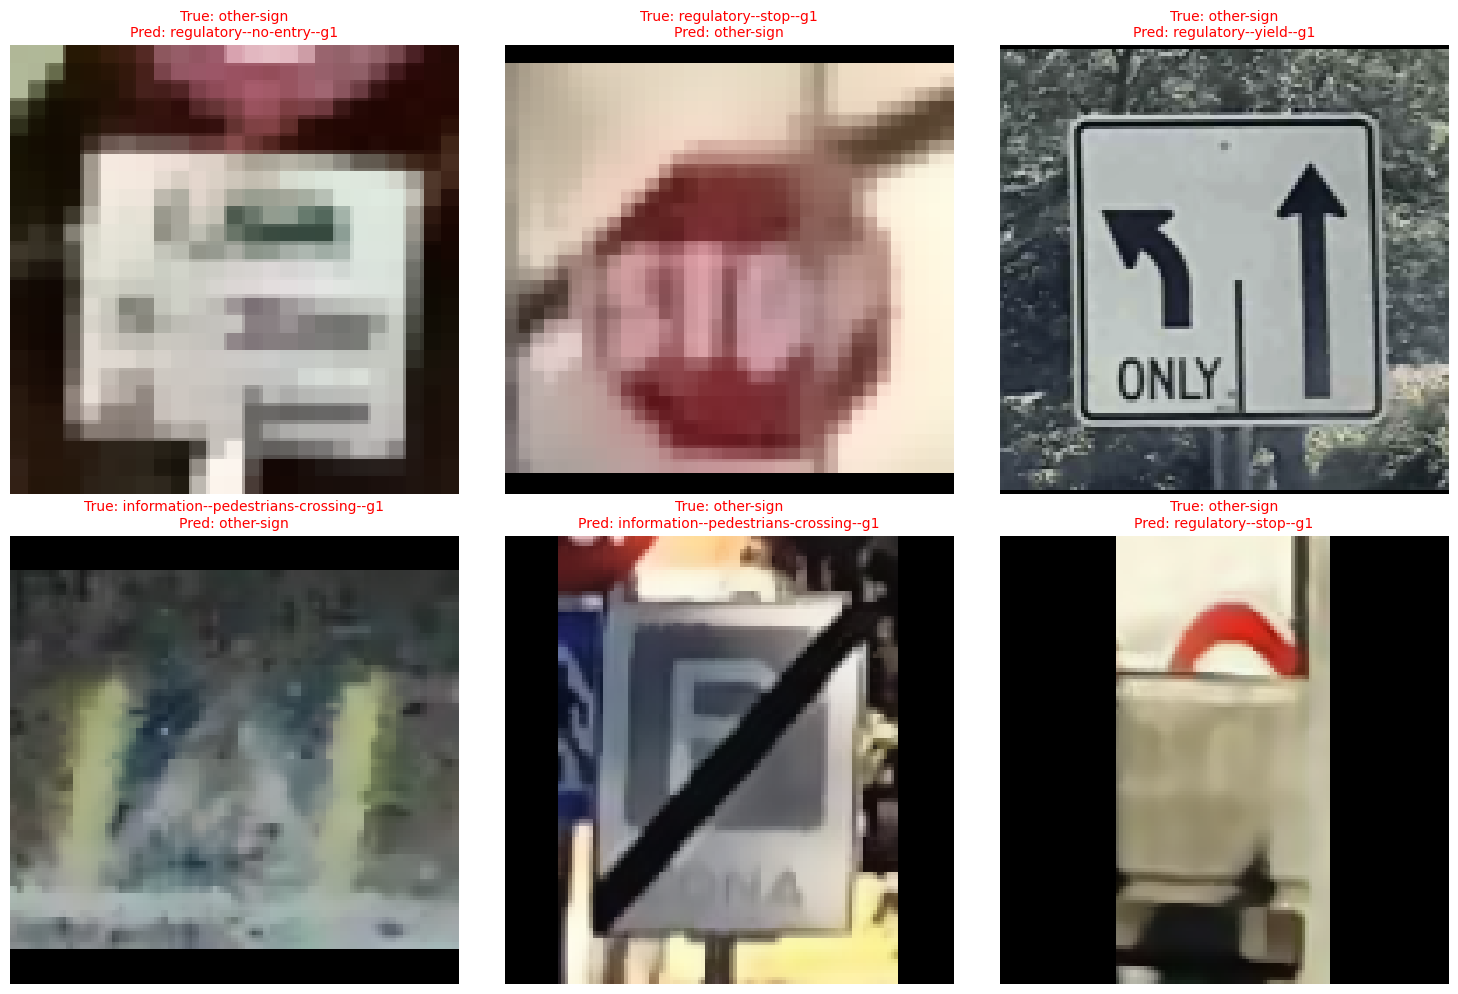

In [15]:
## CELL 7: Failure Analysis (Misclassification Examples)
print("--- Analyzing Misclassifications (SVM Test Set) ---")

# 'clf' is your trained LinearSVC pipeline from Cell 4
# 'X_test', 'y_test' are from Cell 3
# 'test_df' is from Cell 2
# 'id_to_label' is from Cell 2
y_pred_test_ids = clf.predict(X_test)

# Get true labels (as names) and predicted labels (as names)
true_labels_names = test_df['label'].values
pred_labels_names = [id_to_label[id] for id in y_pred_test_ids]

# Get the file paths
test_paths = test_df['crop_path'].values

# Find the indices of the misclassifications
errors = np.where(true_labels_names != pred_labels_names)[0]
print(f"Found {len(errors)} misclassifications in the test set.")

# Plot the first 6 error examples
plt.figure(figsize=(15, 10))
for i, error_idx in enumerate(errors[:6]):
    # Get the original image path
    img_path = test_paths[error_idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    true_label = true_labels_names[error_idx]
    pred_label = pred_labels_names[error_idx]
    
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / "failure_analysis.png")
plt.show()

## Phase 3: Analysis of Results
'''
* **Models:** The LinearSVC achieved an excellent 95.6% test accuracy. The Random Forest achieved 88.2%. Both models prove that the HOG + HSV Histogram features are highly effective for classifying these signs. The SVM is the superior model.
* **HOG Visualization:** The gradient images show what the HOG descriptor "sees." The Gradient Magnitude (far right) clearly outlines the shape of the sign, ignoring uniform color and focusing only on edges, which explains why the classifier works so well.
* **Failure Analysis:** The misclassification plot shows that most errors are understandable. The model confuses `regulatory--no-entry--g1` and `regulatory--stop--g1`, which are both red and have similar circular/octagonal shapes.'''